In [1]:
#импорт библиотек
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, Conv2DTranspose, Input
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
#загрузим датасет

batch_size = 64
image_size = 64

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/ai tests/circles_2',
    label_mode= None,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    interpolation = 'area',
    seed=123
)

#препроцессинг
@tf.function
def process(x):
    #приводим значения пикселей к [0...1]
    return (x/256.0)

dataset = dataset.map(process)
dataset = dataset.shuffle(50).cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)

Found 1000 files belonging to 1 classes.


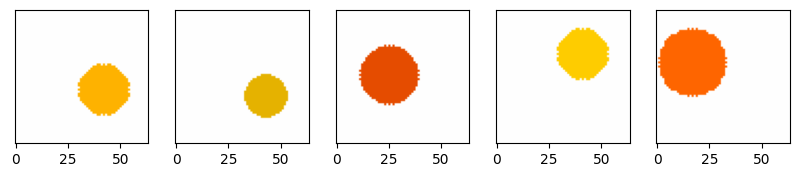

In [12]:
#посмотрим на картинки
def imshow(): 
    n = 5
    plt.figure(figsize=(10, 6))
    #берем один батч из датасета. проходимся по первым n
    for images in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [13]:
#код-сборщик нейросети

#количества фильтров на каждом из сверточных слоев
#с каждым слоем размер картинки уменьшается в 2 раза
widths = [32, 64, 96, 128]

#количество параметров латентного пространства
latent_size = 64

#понижающий блок
def DownBlock(width):
    def apply(x):
        x = Conv2D(width, 3, padding = 'same', activation = keras.activations.swish)(x)
        x = AveragePooling2D(pool_size=2)(x)
        return x
    return apply

#повышающий блок
def UpBlock(width):
    def apply(x):
        x = UpSampling2D(size=2, interpolation="bilinear")(x)
        x = Conv2DTranspose(width, 3, padding = 'same', activation = keras.activations.swish)(x)
        return x
    return apply

def get_encoder(image_size, widths):
    image = keras.Input(shape=(image_size, image_size, 3))
    x = image
    
    for width in widths:
        x = DownBlock(width)(x)
        
    x = Flatten()(x)
    x = Dense(latent_size, activation = 'relu')(x)
    
    return keras.Model(image, x, name="encoder")

def get_decoder(latent_size, widths):
    latent = keras.Input(shape=(latent_size))
    x = Dense(128*4*4, activation = 'relu')(latent)
    x = Reshape((4, 4, 128))(x)
    
    for width in reversed(widths):
        x = UpBlock(width)(x)
        
    x = Conv2D(3, kernel_size=1)(x)
    return keras.Model(latent, x, name="decoder")

In [14]:
class Autoencoder(keras.Model):
    def __init__(self, image_size, latent_size, widths):
        super().__init__()
        
        self.encoder = get_encoder(image_size, widths)
        self.decoder = get_decoder(latent_size, widths)
        
        self.lr = 1e-3
        #Важно! при обучении автоэнкодеров лучше использовать clipnorm
        self.enc_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        self.dec_optimizer = tf.keras.optimizers.Adam(self.lr, clipnorm=1.0)
        
    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape_e,tf.GradientTape() as tape_d:
           
            latent = self.encoder(x, training=True)
            
            reconstructions = self.decoder(latent, training=True)
            
            #расчет среднеквадратичной ошибки попиксельно
            reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2, axis = (1,2,3))
            total_loss = reconstruction_loss
            
        grads_e = tape_e.gradient(total_loss, self.encoder.trainable_variables)
        self.enc_optimizer.apply_gradients(zip(grads_e, self.encoder.trainable_variables))
        
        grads_d = tape_d.gradient(total_loss, self.decoder.trainable_variables)
        self.dec_optimizer.apply_gradients(zip(grads_d, self.decoder.trainable_variables))
        
        return total_loss
    

    
    def testing(self, n):
        '''
        Визуализация.
        n - количество картинок для проверки
        '''
        plt.figure(figsize=(10, 6))
        for images in dataset.take(1):
            latent = self.encoder(images)
            recon = self.decoder(latent)
            for i in range(min(n, len(images))):
                ax = plt.subplot(3, n, i + 1)
                plt.imshow(images[i])
                plt.axis("off")

                ax = plt.subplot(3, n, i + 1 + n)
                plt.imshow(np.clip(recon[i].numpy(), 0, 1))
                plt.axis("off")

        plt.show()

model = Autoencoder(image_size, latent_size, widths)

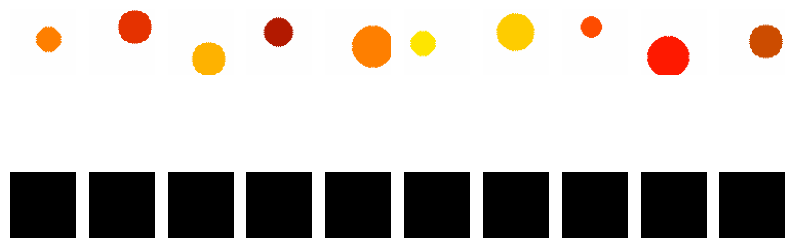

In [15]:
model.testing(10)

эпоха 48
ошибка: 0.0045897276140749454


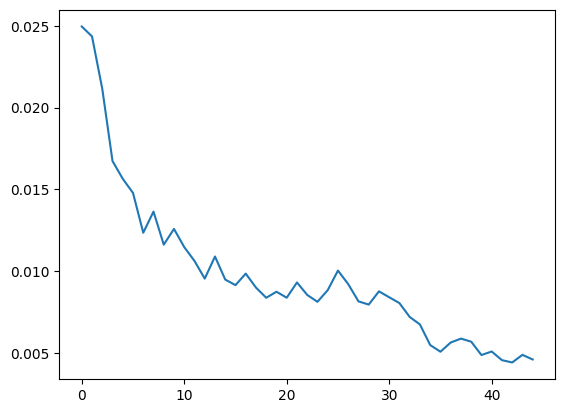

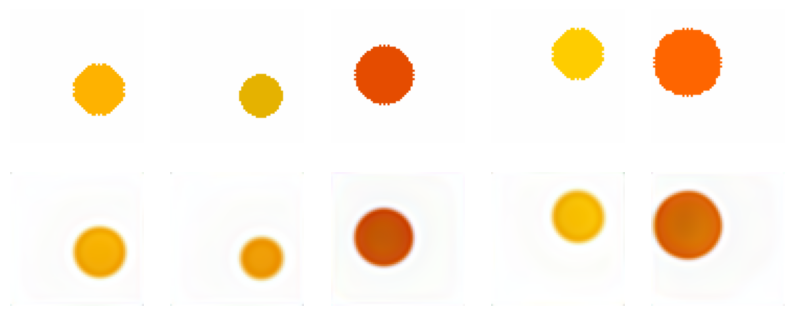

KeyboardInterrupt: 

In [16]:
#обучаем
epochs = 50
hist = np.array(np.empty([0]))
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        if tf.shape(x)[0] == batch_size: #проверяем целостность батча
            midloss += tf.reduce_mean(model.train_step(x), axis = 0)

        if(step == 10 and epoch > 3):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/10)))
           
            hist = np.append(hist, float(midloss/10))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            model.testing(5)

In [17]:
model.encoder.save('encoder_1.h5')
model.decoder.save('decoder_1.h5')

Found 305 files belonging to 1 classes.


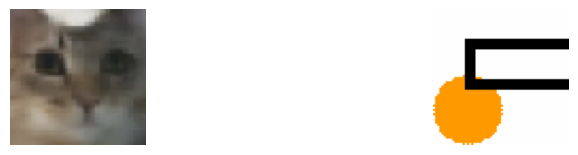

In [20]:
#используем нейросеть для поиска аномалий в данных

#загрузим набор картинок в виде датасета, так будет удобно обрабатывать их батчами
data_to_scan = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/users/user/ai tests/data_with_anomalies',
    label_mode= None,
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True,
    interpolation = 'area',
    seed=123
)

#препроцессинг
@tf.function
def process(x):
    #приводим значения пикселей к [0...1]
    return (x/256.0)

data_to_scan = data_to_scan.map(process)

def detect_anomalies(images, th):
    '''
    входные данные:
    images - тензор картинок для обработки формы (b,h,w,3)
    th - поргог среднеквадратичной ошибки восстановленной картинки
    
    выходные данные:
    Функция вернет список номеров 'аномальных' картинок, если они есть.
    
    '''
    latents = model.encoder(images)
    recons = model.decoder(latents)
    losses = tf.reduce_mean((images - recons) ** 2, axis = (1,2,3))
    losses = losses.numpy()
    results = []
    for n, l in enumerate(losses):
        if l > th:
            results.append(n)
    return results

anomalies = []
for b in data_to_scan:
    res = detect_anomalies(b, 0.1)
    for n in res:
        anomalies.append(b[n])

n_anomalies = len(anomalies)
plt.figure(figsize=(10, 6))
for n in range(n_anomalies):
    ax = plt.subplot(3, n_anomalies, n + 1)
    plt.imshow(anomalies[n])
    plt.axis("off")
plt.show()